# Testing
Adding in data scaling and encoding from the beginning.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.linear_model import LinearRegression, Lasso, Ridge

print(np.NaN)

nan


In [3]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


Our data has 1000 rows and 17 columns: 6 columns of numeric data and 11 with categoric data. You can find a thorough analysis of them in the EDA notebook.

Before doing any analysis, we need to prepare our data.

## 1 - Data preprocessing

First, encode the categorical data using dummy variables, since ```sklearn``` is designed only for numeric data.

We drop the 'Address' column, because most of its values are unique so it would blow up our feature set without adding much value.

In [12]:
# Check how many unique values are in the addresses column of the housing_train_test_df
print(f'Unique addresses: {housing_df["Address"].nunique()}')

# Drop the Address column, apply get_dummies to the remaining categorical columns
housing_df_encoded = pd.get_dummies(housing_df.drop(columns=['Address']),
                                       drop_first=True).astype(np.float32)

cols_encoded = housing_df_encoded.columns#.tolist()
print(f'Columns after encoding ({len(cols_encoded)}): {cols_encoded}')
housing_df_encoded.shape

Unique addresses: 770
Columns after encoding (36): Index(['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors',
       'Price (£)', 'Neighborhood_Chelsea', 'Neighborhood_Greenwich',
       'Neighborhood_Islington', 'Neighborhood_Kensington',
       'Neighborhood_Marylebone', 'Neighborhood_Notting Hill',
       'Neighborhood_Shoreditch', 'Neighborhood_Soho',
       'Neighborhood_Westminster', 'Garden_Yes', 'Garage_Yes',
       'Property Type_Detached House', 'Property Type_Semi-Detached',
       'Heating Type_Electric Heating', 'Heating Type_Gas Heating',
       'Heating Type_Underfloor Heating', 'Balcony_Low-level Balcony',
       'Balcony_No Balcony', 'Interior Style_Industrial',
       'Interior Style_Minimalist', 'Interior Style_Modern', 'View_Garden',
       'View_Park', 'View_Sea', 'View_Street', 'Materials_Laminate Flooring',
       'Materials_Marble', 'Materials_Wood', 'Building Status_Old',
       'Building Status_Renovated'],
      dtype='object')


(1000, 36)

Second, let's set aside 100 randomly selected rows to be used for evaluating the model outputs later.

In [8]:
evaluation_set = housing_df_encoded.sample(frac=0.1, random_state=24)
train_test_df = housing_df_encoded.drop(evaluation_set.index).reset_index(drop=True)
evaluation_df = evaluation_set.reset_index(drop=True)

Third, we separate out our features and target variable, and perform a train-test split on ```train_test_df```.

In [40]:
# Separate evluation set into features and target variable
X_eval = evaluation_df.drop(columns=['Price (£)']).values
y_eval = evaluation_df['Price (£)'].values
# Separate train_test_df into features and target variable
X = train_test_df.drop(columns=['Price (£)']).values
y = train_test_df['Price (£)'].values

# Perform train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)
print('Training data shape: ', X_test.shape, y_test.shape)
print('Test data shape: ', X_test.shape, y_test.shape)
print('Evaluation data shape: ', X_eval.shape, y_eval.shape)

Training data shape:  (270, 35) (270,)
Test data shape:  (270, 35) (270,)
Evaluation data shape:  (100, 35) (100,)


Fourth and finally, scale the feature data using ```StandardScaler()```.

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_eval_scaled = scaler.transform(X_eval)

Now we're ready to model!

## 2 - only look at house size
It's often mentioned that the most important factor in determining house prices is the size.

Let's take a look at that idea by building models using only the 'Square Meters' data.

In [58]:
# Get Square Meters data
X_train_sqm = X_train[:, cols_encoded.get_loc('Square Meters')].reshape(-1, 1)
X_test_sqm = X_test[:, cols_encoded.get_loc('Square Meters')].reshape(-1, 1)

# Instantiate models
models_sqm = {'Linear (SQM-only)': LinearRegression(),
            #   'Lasso (SQM-only)': Lasso(alpha = 0.1),
              'Ridge (SQM-only)': Ridge(alpha = 0.1)}

Next we fit the models to the training data, evaluate their $R^2$ score, and then generate and plot predictions using the test data.

We create a function for this since we will want to repeat it again later.

In [59]:
def score_predict_plot(model_dict, X_train, y_train, X_test, y_test, X_test1D, title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', marker='D',
                color='black', alpha=0.9, s=20)
    
    # Loop over models
    for model_name, model in model_dict.items():
        # Fit, redict and plot
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        # Calculate and print R² scores
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Linear (SQM-only) training--testing R²: 0.6412--0.6065
Lasso (SQM-only) training--testing R²: 0.6412--0.6065
Ridge (SQM-only) training--testing R²: 0.6412--0.6065


/Users/matt/opt/anaconda3/envs/root_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.990e+13, tolerance: 4.880e+10
  model = cd_fast.enet_coordinate_descent(


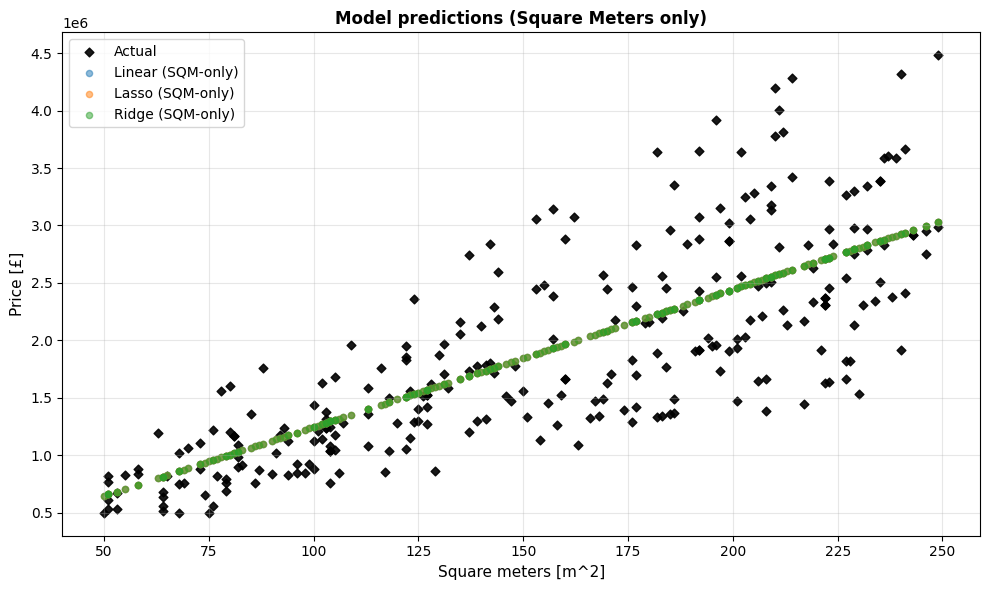

In [56]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train, X_test_sqm, y_test, X_test_sqm,
                   title='Model predictions (Square Meters only)')

We can see the models have drawn a straight line through the data, as linear regression models are designed to do.

The models' $R^2$ scores of around 0.6 means they explain 60% of the variance in the data.

Let's go slightly deeper on the performance with some cross validation.

In [60]:
from sklearn.model_selection import KFold, cross_val_score
kf20 = KFold(n_splits=10, shuffle=True, random_state=23)

print('cross-validation scores: min--mean--max (std.)')
def cross_val_models(models_dict, X, y, cv):
    for model_name, model in models_dict.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        print(f'{model_name}: {np.min(cv_scores):.3f} --- {np.mean(cv_scores):.3f} --- {np.max(cv_scores):.3f} ({cv_scores.std():.3f})')
    return

print('Cross-validation on training set:')
cross_val_models(models_sqm, X_train_sqm, y_train, kf20)
print('Cross-validation on test set:')
cross_val_models(models_sqm, X_test_sqm, y_test, kf20)

cross-validation scores: min--mean--max (std.)
Cross-validation on training set:
Linear (SQM-only): 0.504 --- 0.629 --- 0.725 (0.065)
Ridge (SQM-only): 0.504 --- 0.629 --- 0.725 (0.065)
Cross-validation on test set:
Linear (SQM-only): 0.258 --- 0.571 --- 0.886 (0.158)
Ridge (SQM-only): 0.258 --- 0.571 --- 0.886 (0.158)


After checking the model scores across 20 different cross validation folds, we see the $R^2$ can go pretty low, but in general it's around 0.5-0.7 - not great, but not bad for a single feature.

Interestingly, the models all produce idental results and scores.

Let's make some models that take advantage of all of the data.

## 3 - look at all data
Let's now see how well the models can do with all the data available.

In [61]:
# Instantiate models for all features
models_all = {'Linear (All)': LinearRegression(),
              'Lasso (All)': Lasso(alpha = 0.1),
              'Ridge (All)': Ridge(alpha = 0.1)}

# Fit each model and print R² scores
for model_name, model in models_all.items():
    model.fit(X_train_scaled, y_train)
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")

Linear (All) training--testing R²: 0.9472--0.9505
Lasso (All) training--testing R²: 0.9472--0.9505
Ridge (All) training--testing R²: 0.9472--0.9505


/Users/matt/opt/anaconda3/envs/root_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.600e+11, tolerance: 4.880e+10
  model = cd_fast.enet_coordinate_descent(


Wow - a 50% increase in the $R^2$ values! The test and training $R^2$ values are also close, which is good because it implies we've avoided overfitting.

Now let's do some hyperparameter tuning for the Lasso and Ridge models.

### Tuning

We'll use ```sklearn```'s ```RandomizedSearchCV``` function.

In [62]:
from sklearn.model_selection import RandomizedSearchCV

# Set the hyperparameter grids for Lasso and Ridge
params = {'alpha': np.linspace(0.001, 10, 100)}

randomCV_lasso_all = RandomizedSearchCV(models_all['Lasso (All)'], params,
                                        cv=kf20, n_iter=20, random_state=24)
randomCV_ridge_all = RandomizedSearchCV(models_all['Ridge (All)'], params,
                                        cv=kf20, n_iter=20, random_state=24)

models_all_cvs = {
    'Lasso Regression (All)': randomCV_lasso_all,
    'Ridge Regression (All)': randomCV_ridge_all
}

In [64]:
results_dict = {}
for name, model in models_all_cvs.items():
    model.fit(X_train_scaled, y_train)
    print('{} {} {}'.format(5*'-', name, 5*'-'))
    print(f'Top score: {model.best_score_:.4f}')
    print(f'Top params: {model.best_params_}')
    results_dict[name] = [model.best_score_, model.best_params_]

----- Lasso Regression (All) -----
Top score: 0.9402
Top params: {'alpha': 9.495}
----- Ridge Regression (All) -----
Top score: 0.9403
Top params: {'alpha': 3.738}


We see the best performing models had alpha values of around:
- **9.50** for Lasso 
- **3.78** for Ridge.

Let's save those best models and see how the predictions look now using our plotting fucntion defined earlier.

Linear Regression (All) training--testing R²: 0.9472--0.9505
Best Lasso (All) training--testing R²: 0.9472--0.9505
Best Ridge (All) training--testing R²: 0.9471--0.9501


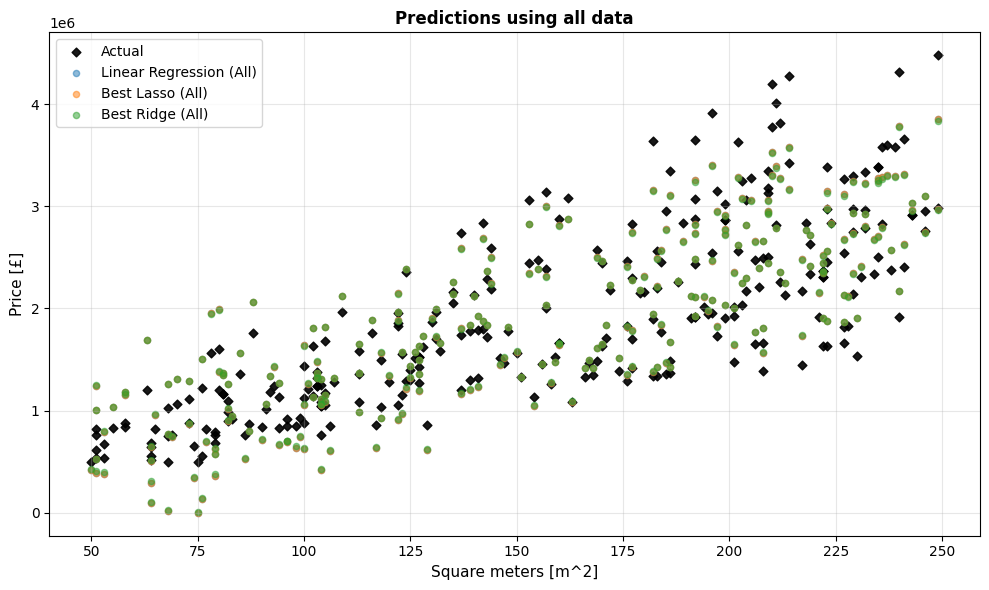

In [65]:
best_models = {
    'Linear Regression (All)': models_all['Linear (All)'],
    'Best Lasso (All)': randomCV_lasso_all.best_estimator_,
    'Best Ridge (All)': randomCV_ridge_all.best_estimator_
}

score_predict_plot(best_models,
                   X_train_scaled, y_train, X_test_scaled, y_test,
                   X_test_sqm, title='Predictions using all data')

The predictions look much better, especially in the middle - at the lower the predictions are a bit too spread out and at the higher end they are too clustered.

### Model Evaluation
Now that we are satisfied with our models, we can finally use our evaluation set to see how well they do on unseen data.

First, let's plot how our predictions look on a graph.

Linear Regression (All) eval R²: 0.9374
Best Lasso (All) eval R²: 0.9375
Best Ridge (All) eval R²: 0.9372


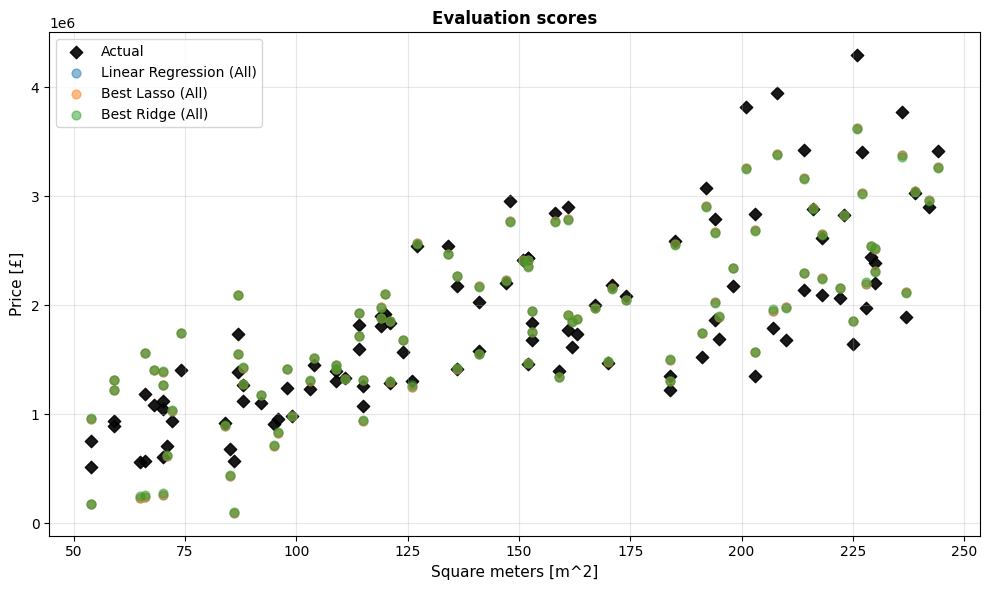

In [76]:
# Create figure and plot the actual results
plt.figure(figsize=(10, 6))
plt.scatter(X_eval[:, 2], y_eval, label='Actual', marker='D',
            color='black', alpha=0.9, s=40)

eval_set_preds = {}
# Loop over models
for model_name, model in best_models.items():
    # Predict and plot
    eval_set_preds[model_name] = model.predict(X_eval_scaled)
    plt.scatter(X_eval[:, 2], eval_set_preds[model_name], label=model_name, alpha=0.5, s=40)
    # Calculate and print R² scores
    eval_score = model.score(X_eval_scaled, y_eval)
    print(f"{model_name} eval R²: {eval_score:.4f}")
    
plt.xlabel('Square meters [m^2]', fontsize=11)
plt.ylabel('Price [£]', fontsize=11)
plt.title('Evaluation scores', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We see the $R^2$ remains high, which means the models do well at explaining the variation even in unseen data.

But how good are they at actually predicting house prices?

To understand this, we'll evluate the models on 3 key parameters:
- The Root Mean Squared Error (RMSE)
- The Mean Aboslute Error (MAE) - this tells us on average how close our models' estimates are in £.
- The Mean Aboslute Percentage Error (MAPE) - this tells us on average how close our models' estimates are in percentage terms.

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [91]:
# Write a function to loop over a model dict and save their R2, MSE, RMSE, MAE and MAPE scores to a dictionary
def eval_models(model_dict, prediction_dict, y):
    model_scores = {}
    for model_name, model in model_dict.items():
        print(model_name)
        model_scores[model_name] = []
        # R2 score
        print('R2 score:', r2_score(y_eval, prediction_dict[model_name]))
        model_scores[model_name].append(r2_score(y_eval, prediction_dict[model_name]))
        # MSE
        print('RMSE:', np.sqrt(mean_squared_error(y_eval, prediction_dict[model_name])))
        model_scores[model_name].append(np.sqrt(mean_squared_error(y_eval, prediction_dict[model_name])))
        # MAE
        print('MAE:', mean_absolute_error(y_eval, prediction_dict[model_name]))
        model_scores[model_name].append(mean_absolute_error(y_eval, prediction_dict[model_name]))
        # MAPE
        mape = np.mean(np.abs((y_eval - prediction_dict[model_name]) / y_eval)) * 100
        print('MAPE:', mape)
        model_scores[model_name].append(mape)
    return model_scores

In [92]:
eval_models(best_models, eval_set_preds, y_eval)

Linear Regression (All)
R2 score: 0.9374392032623291
RMSE: 206933.88316078158
MAE: 157327.515625
MAPE: 11.738719791173935
Best Lasso (All)
R2 score: 0.9374503493309021
RMSE: 206915.3652680245
MAE: 157316.5625
MAPE: 11.73660010099411
Best Ridge (All)
R2 score: 0.9371587038040161
RMSE: 207397.17197686183
MAE: 157655.859375
MAPE: 11.625893414020538


{'Linear Regression (All)': [0.9374392032623291,
  206933.88316078158,
  157327.515625,
  11.738719791173935],
 'Best Lasso (All)': [0.9374503493309021,
  206915.3652680245,
  157316.5625,
  11.73660010099411],
 'Best Ridge (All)': [0.9371587038040161,
  207397.17197686183,
  157655.859375,
  11.625893414020538]}

#### Residual analysis

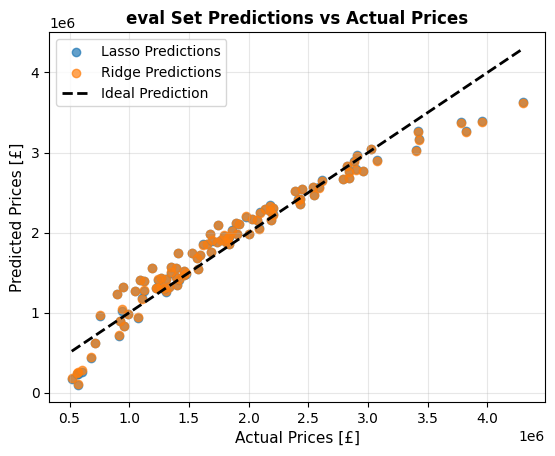

In [68]:
best_lasso_preds = best_models['Best Lasso (All)'].predict(X_eval_scaled)
best_ridge_preds = best_models['Best Ridge (All)'].predict(X_eval_scaled)

plt.scatter(y_eval, best_lasso_preds, label='Lasso Predictions', alpha=0.7)
plt.scatter(y_eval, best_ridge_preds, label='Ridge Predictions', alpha=0.7)
plt.plot([y_eval.min(), y_eval.max()],
         [y_eval.min(), y_eval.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Prices [£]', fontsize=11)
plt.ylabel('Predicted Prices [£]', fontsize=11)
plt.title('eval Set Predictions vs Actual Prices', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)